## Importing Necessary Packages

In [5]:
import pandas as pd
import numpy as np
import scipy as sc
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

## Function to convert unstacked dataframe into a sparse matrix

In [6]:
def convert_to_sparse_matrix(df, shape, mat_type='csr', rows='user_id', cols='song_id', val = 'listen_count'):
    df_matrix = np.zeros(shape=shape)
    for index, row in df.iterrows():
        df_matrix[row[rows], row[cols]] = row[val]

    if mat_type=='csr':
        df_matrix = sc.sparse.csr_matrix(df_matrix)
    elif mat_type=='coo':
        df_matrix = sc.sparse.coo_matrix(df_matrix)

    return df_matrix

## Function to help with building models on different datasets

In [7]:
def build_lightfm_model(df_train_coo, df_val_coo,df_test_coo, item_features='None'):

    perf_metrics = {}
    for n_components in range(1,26):
        perf_metrics[n_components] = {}
        model = LightFM(no_components=n_components, k=10, loss='warp')
        model.fit(df_train_coo, epochs=10, item_features=item_features)
        perf_metrics[n_components]['n_precision_at_k'] = int(sum(precision_at_k(model, df_val_coo, item_features=item_features)*10))
        perf_metrics[n_components]['mean_precision_at_k'] = np.mean(precision_at_k(model, df_val_coo, item_features=item_features))
        perf_metrics[n_components]['mean_recall_at_k'] = np.mean(recall_at_k(model, df_val_coo, item_features=item_features))
        perf_metrics[n_components]['mean_auc'] = np.mean(auc_score(model, df_val_coo, item_features=item_features))
        perf_metrics[n_components]['reciprocal_rank'] = np.mean(reciprocal_rank(model, df_val_coo, item_features=item_features))
        
    metrics_df = pd.DataFrame(perf_metrics).T
    
    best_k = np.argmax(metrics_df['n_precision_at_k'])
    
    model = LightFM(no_components=best_k, k=10, loss='warp')
    model.fit(df_train_coo, epochs=10, item_features=item_features)
    
    
    n_precision_at_k_test = int(sum(precision_at_k(model, df_test_coo, item_features=item_features)*10))
    mean_precision_at_k_test = np.mean(precision_at_k(model, df_test_coo, item_features=item_features))
    reciprocal_rank_test = np.mean(reciprocal_rank(model, df_test_coo, item_features=item_features))
    auc_score_test = np.mean(auc_score(model, df_test_coo, item_features=item_features))
    
    return model, n_precision_at_k_test, mean_precision_at_k_test, reciprocal_rank_test, auc_score_test, metrics_df

## Function to recommend top k items from the model

In [127]:
def recommend_items(user, model, item_features, k=5):
    user_id_lkup = user2idx[user]
    
    known_positives = np.argsort(np.array(df_train_coo.todense()[user_id_lkup])).T[::-1][:k]
    known_positives = [idx2song[song_listened] for song_listened in list(known_positives.ravel())]
    
    print('Listened Songs (from Train Dataset):')

    for song_listened in known_positives:
        song = list(song_info[song_info['song_id']==song_listened][['artist_name', 'track_name']].iloc[0])
        print ('Artist:', song[0], '& Song:', song[1])
    
    predictions = model.predict(user_id_lkup, list(range(len(idx2song))), item_features=item_features)
    predictions_sorted = np.argsort(predictions)[::-1]
    pred_list = [idx2song[pred] for pred in predictions_sorted[:k]]
   
    print('')
    print('Recommended Songs:')

    for pred in pred_list:
        song = list(song_info[song_info['song_id']==pred][['artist_name', 'track_name']].iloc[0])
        print ('Artist:', song[0], '& Song:', song[1])

## Functions to compute baseline metrics

In [63]:
def baseline_top_items_n_precision_at_k(df_train_coo, df_test_coo, k):
    top_songs_indices = np.argsort((np.where(df_train_coo.todense()>0, 1, 0)).sum(axis=0))[::-1]
    df_test_pred = np.zeros_like(df_test_coo.todense())
    for val in top_songs_indices[:k]:
        df_test_pred[:,val] = 1
    listened_songs = np.where(df_test_coo.todense()>0, 1, 0)
    baseline_n_precision_at_k = (np.multiply(df_test_pred, listened_songs)).sum()
    
    return baseline_n_precision_at_k

In [66]:
def baseline_top_items_reciprocal_rank(df_train_coo, df_test_coo):
    top_songs_indices = np.argsort((np.where(df_train_coo.todense()>0, 1, 0)).sum(axis=0))[::-1]
    recip_rank_baseline = []
    for user in range(df_test_coo.shape[0]):
        listened_songs_user_indices = np.argwhere(df_test_coo.todense()[user])[:,1]
        if len(listened_songs_user_indices>0):
            rank = min([np.argwhere(top_songs_indices==val) for val in listened_songs_user_indices])+1
            recip_rank_baseline.append(1.0/rank)
        else: recip_rank_baseline.append(0)
    return np.mean(recip_rank_baseline)[0][0]

## Running the Model on a larger dataset - 10K Users and 2780 Songs

In [44]:
playcount_df = pd.read_csv('10kusers_5ksongs.gz')
song_info = pd.read_csv('song_info.csv')
genre = pd.read_csv('genre.csv')

df_song_info = pd.merge(playcount_df, song_info, how='inner', on='song_id')
df_song_info_genre = pd.merge(df_song_info, genre, how='inner', on='track_id')

songs = df_song_info_genre['song_id'].unique()
users = df_song_info_genre['user_id'].unique()
genres = df_song_info_genre['genre'].unique()
artists = df_song_info_genre['artist_name'].unique()

# Users
user2idx = {u : i for i, u in enumerate(users)}
idx2user = {i : u for i, u in enumerate(users)}

# Songs
song2idx = {u : i for i, u in enumerate(songs)}
idx2song = {i : u for i, u in enumerate(songs)}

# Genre
genre2idx = {u : i for i, u in enumerate(genres)}
idx2genre = {i : u for i, u in enumerate(genres)}

# Artist
artist2idx = {u : i for i, u in enumerate(artists)}
idx2artist = {i : u for i, u in enumerate(artists)}

df_ids = df_song_info_genre[['user_id', 'song_id', 'listen_count']]
df_ids['song_id'] = df_ids['song_id'].map(song2idx)
df_ids['user_id'] = df_ids['user_id'].map(user2idx)

df_train, df_test = train_test_split(df_ids, train_size=0.8, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, train_size=0.8, test_size=0.2, random_state=42)

df_train_coo = convert_to_sparse_matrix(df_train, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))
df_val_coo = convert_to_sparse_matrix(df_val, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))
df_test_coo = convert_to_sparse_matrix(df_test, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))


song_genres = df_song_info_genre[['song_id', 'genre']].drop_duplicates()
song_genres['song_id'] = song_genres['song_id'].map(song2idx)
song_genres['genre'] = song_genres['genre'].map(genre2idx)
song_genres['onehot'] = 1
genre_csr = convert_to_sparse_matrix(song_genres, mat_type='csr', rows='song_id', cols='genre', val='onehot', shape=(len(idx2song), len(idx2genre)))
song_artists = df_song_info_genre[['song_id', 'artist_name']].drop_duplicates()
song_artists['song_id'] = song_artists['song_id'].map(song2idx)
song_artists['artist'] = song_artists['artist_name'].map(artist2idx)
song_artists['onehot'] = 1
artist_csr = convert_to_sparse_matrix(song_artists, mat_type='csr', rows='song_id', cols='artist', val='onehot', shape=(len(idx2song), len(idx2artist)))
full_item_features_csr = sc.sparse.csr_matrix(np.hstack((genre_csr.todense(), artist_csr.todense())))

/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Model without Side Information

In [45]:
model, n_precision_at_k_test, mean_precision_at_k_test, reciprocal_rank_test, auc_score_test, metrics_df = build_lightfm_model(df_train_coo, df_val_coo,df_test_coo, item_features=None)

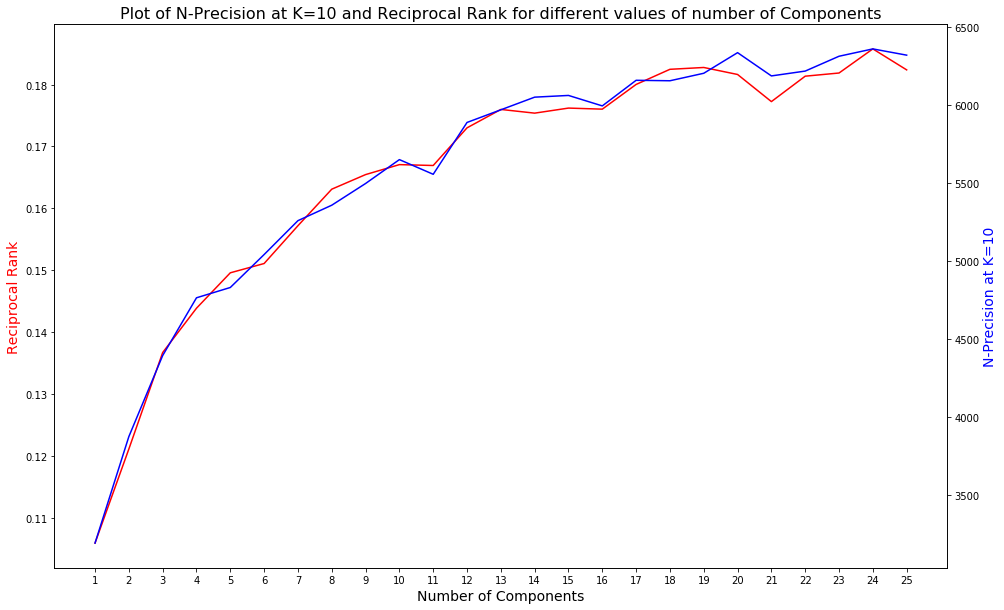

In [48]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [49]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo, item_features=None)*10)))
print("Mean reciprocal rank across all users: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo, item_features=None))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo, item_features=None))))

Number of listened predictions across all users: 7770
Mean reciprocal rank across all users: 0.212
Mean auc score across all users: 0.843


In [50]:
recommend_items(user = 'c51ff54138c508b897d4ed3b9d099e76dbec880a', model=model, item_features=None)

Listened Songs (from Train Dataset):
Artist: Dwight Yoakam & Song: You're The One
Artist: Subhumans & Song: Rain
Artist: John Mayer & Song: Heartbreak Warfare
Artist: Junior Boys & Song: A Certain Association
Artist: CSS & Song: Meeting Paris Hilton (Album)

Recommended Songs:
Artist: La Roux | Song: Bulletproof
Artist: OneRepublic | Song: Secrets
Artist: Florence + The Machine | Song: Cosmic Love
Artist: Passion Pit | Song: Sleepyhead
Artist: Chromeo | Song: Fancy Footwork


## Model with Artist and Genre Side Information

In [51]:
model_full, n_precision_at_k_test_full, mean_precision_at_k_test_full, reciprocal_rank_test_full, auc_score_test_full, metrics_df_full = build_lightfm_model(df_train_coo, df_val_coo,df_test_coo, item_features=full_item_features_csr)

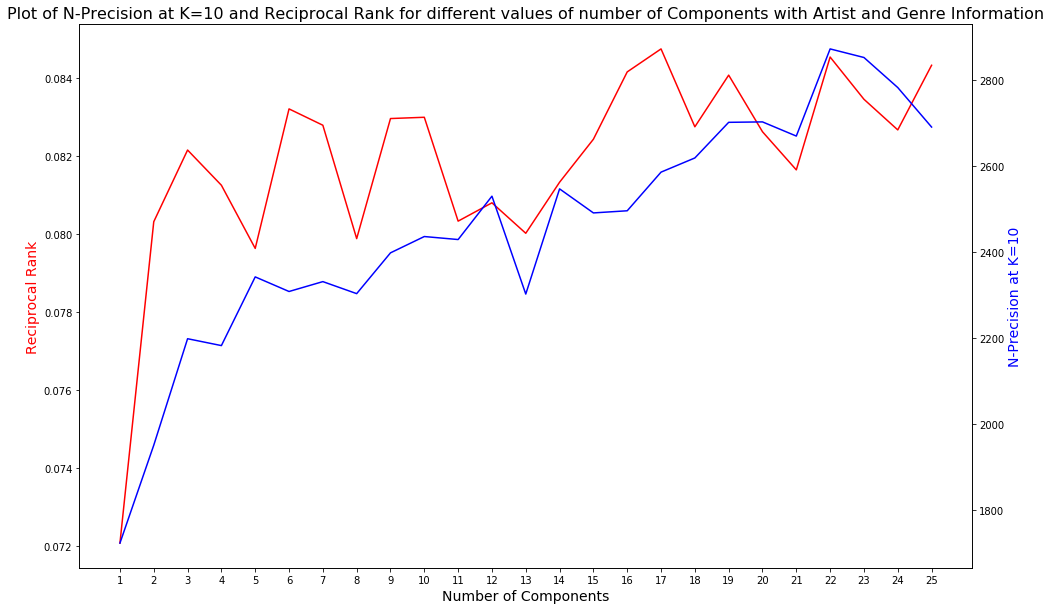

In [52]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df_full['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df_full['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components with Artist and Genre Information', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [53]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model_full, df_test_coo, item_features=full_item_features_csr)*10)))
print("Mean reciprocal rank across all users: {0:.3f}".format(np.mean(reciprocal_rank(model_full, df_test_coo, item_features=full_item_features_csr))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model_full, df_test_coo, item_features=full_item_features_csr))))

Number of listened predictions across all users: 3359
Mean reciprocal rank across all users: 0.097
Mean auc score across all users: 0.842


In [54]:
recommend_items(user = 'c51ff54138c508b897d4ed3b9d099e76dbec880a', model=model_full, item_features=full_item_features_csr)

Listened Songs (from Train Dataset):
Artist: Dwight Yoakam & Song: You're The One
Artist: Subhumans & Song: Rain
Artist: John Mayer & Song: Heartbreak Warfare
Artist: Junior Boys & Song: A Certain Association
Artist: CSS & Song: Meeting Paris Hilton (Album)

Recommended Songs:
Artist: La Roux | Song: Bulletproof
Artist: Five Iron Frenzy | Song: Canada
Artist: Lonnie Gordon | Song: Catch You Baby (Steve Pitron & Max Sanna Radio Edit)
Artist: Dwight Yoakam | Song: You're The One
Artist: Cosmo Vitelli | Song: Robot Soul (Radio Edit)


## Recomputation of baseline metrics on the larger dataset

In [64]:
baseline_top_items_n_precision_at_k(df_train_coo=df_train_coo, df_test_coo=df_test_coo, k=10)

3070.0

In [67]:
baseline_top_items_reciprocal_rank(df_train_coo=df_train_coo, df_test_coo=df_test_coo)

0.1001849597347831

## Running the model for different user sets - Sparse and Dense Users

In [233]:
playcount_df = pd.read_csv('10kusers_500songs.csv')
song_info = pd.read_csv('song_info.csv')
genre = pd.read_csv('genre.csv')

In [234]:
df_song_info = pd.merge(playcount_df, song_info, how='inner', on='song_id')
df_song_info_genre = pd.merge(df_song_info, genre, how='inner', on='track_id')

In [235]:
user_song_counts = df_song_info_genre.groupby('user_id')['song_id'].count().reset_index()
user_song_counts.columns = ['user_id', 'song_counts']
sparse_users = user_song_counts[user_song_counts['song_counts']<10][['user_id']]
dense_users = user_song_counts[user_song_counts['song_counts']>20][['user_id']]

## Histogram of Number of Songs Listened to by the Users

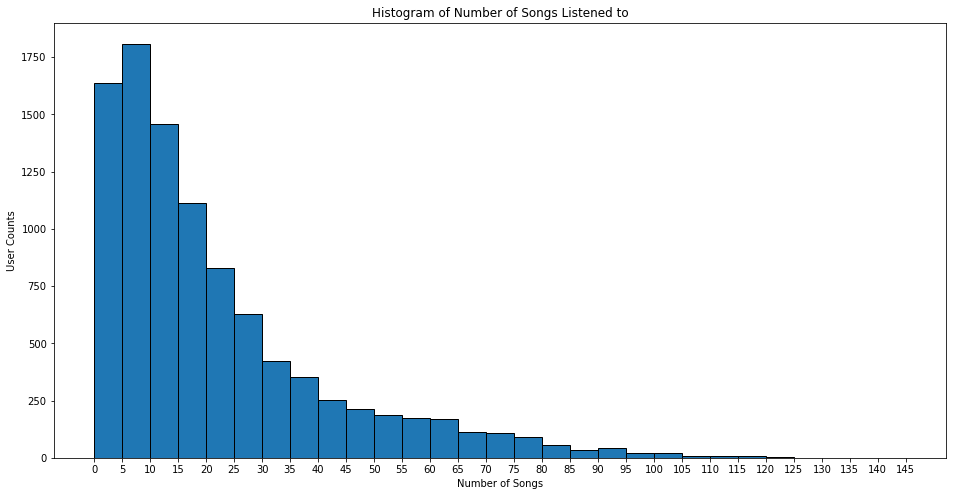

In [221]:
plt.figure(figsize=(16,8))
plt.hist(user_song_counts['song_counts'], edgecolor='black', bins=range(0,150,5))
plt.xticks(range(0,150,5))
plt.title('Histogram of Number of Songs Listened to')
plt.ylabel('User Counts')
plt.xlabel('Number of Songs')
plt.show()

In [222]:
print('Number of users in the sparse set:', len(sparse_users))
print('Number of users in the dense set:', len(dense_users))

Number of users in the sparse set: 3447
Number of users in the dense set: 3558


## Running the Model on a Sparse Dataset - Users who listened to <10 different songs

In [236]:
df_song_info_genre = pd.merge(df_song_info_genre, sparse_users, how='inner', on='user_id')

In [237]:
%%capture --no-stderr
songs = df_song_info_genre['song_id'].unique()
users = df_song_info_genre['user_id'].unique()
genres = df_song_info_genre['genre'].unique()
artists = df_song_info_genre['artist_name'].unique()

# Users
user2idx = {u : i for i, u in enumerate(users)}
idx2user = {i : u for i, u in enumerate(users)}

# Songs
song2idx = {u : i for i, u in enumerate(songs)}
idx2song = {i : u for i, u in enumerate(songs)}

# Genre
genre2idx = {u : i for i, u in enumerate(genres)}
idx2genre = {i : u for i, u in enumerate(genres)}

# Artist
artist2idx = {u : i for i, u in enumerate(artists)}
idx2artist = {i : u for i, u in enumerate(artists)}

df_ids = df_song_info_genre[['user_id', 'song_id', 'listen_count']]
df_ids['song_id'] = df_ids['song_id'].map(song2idx)
df_ids['user_id'] = df_ids['user_id'].map(user2idx)

df_train, df_test = train_test_split(df_ids, train_size=0.8, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, train_size=0.8, test_size=0.2, random_state=42)

df_train_coo = convert_to_sparse_matrix(df_train, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))
df_val_coo = convert_to_sparse_matrix(df_val, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))
df_test_coo = convert_to_sparse_matrix(df_test, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))


song_genres = df_song_info_genre[['song_id', 'genre']].drop_duplicates()
song_genres['song_id'] = song_genres['song_id'].map(song2idx)
song_genres['genre'] = song_genres['genre'].map(genre2idx)
song_genres['onehot'] = 1
genre_csr = convert_to_sparse_matrix(song_genres, mat_type='csr', rows='song_id', cols='genre', val='onehot', shape=(len(idx2song), len(idx2genre)))
song_artists = df_song_info_genre[['song_id', 'artist_name']].drop_duplicates()
song_artists['song_id'] = song_artists['song_id'].map(song2idx)
song_artists['artist'] = song_artists['artist_name'].map(artist2idx)
song_artists['onehot'] = 1
artist_csr = convert_to_sparse_matrix(song_artists, mat_type='csr', rows='song_id', cols='artist', val='onehot', shape=(len(idx2song), len(idx2artist)))
full_item_features_csr = sc.sparse.csr_matrix(np.hstack((genre_csr.todense(), artist_csr.todense())))

/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Model with No Side Information

In [238]:
model, n_precision_at_k_test, mean_precision_at_k_test, reciprocal_rank_test, auc_score_test, metrics_df = build_lightfm_model(df_train_coo, df_val_coo,df_test_coo, item_features=None)

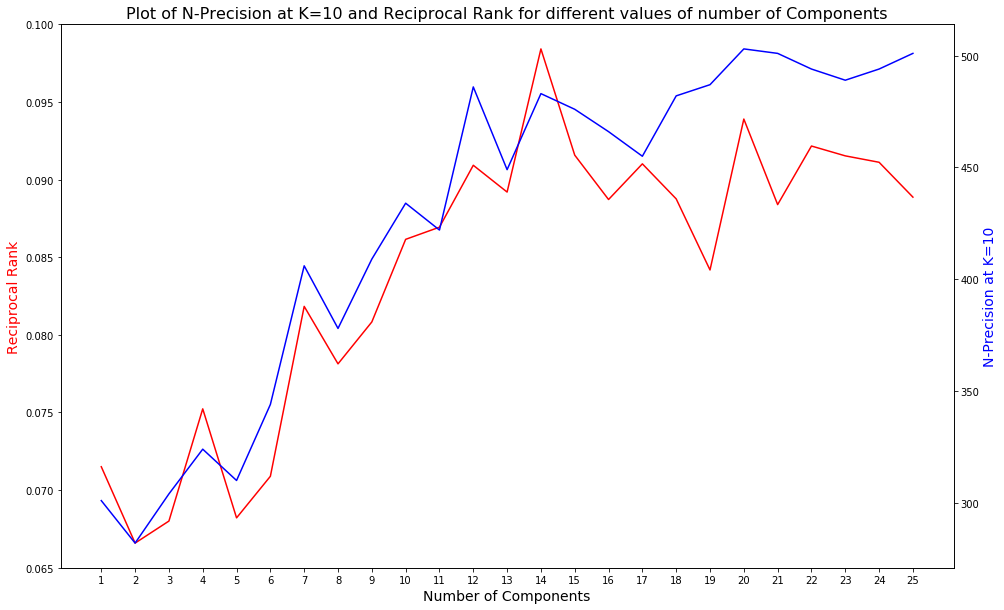

In [114]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [115]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo, item_features=None)*10)))
print("Mean reciprocal rank across all users: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo, item_features=None))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo, item_features=None))))

Number of listened predictions across all users: 627
Mean reciprocal rank across all users: 0.100
Mean auc score across all users: 0.758


## Recomputation of baseline metrics on the sparse dataset

In [154]:
baseline_top_items_n_precision_at_k(df_train_coo=df_train_coo, df_test_coo=df_test_coo, k=10)

387.0

In [155]:
baseline_top_items_reciprocal_rank(df_train_coo=df_train_coo, df_test_coo=df_test_coo)

0.04800217427949938

In [175]:
recommend_items(user = idx2user[1900], model=model, item_features=None)

Listened Songs (from Train Dataset):
Artist: Boys Noize & Song: Let´s Buy Happiness
Artist: Coldplay & Song: In My Place
Artist: The Black Keys & Song: I'll Be Your Man
Artist: Cat Stevens & Song: Wild World
Artist: Simian Mobile Disco & Song: Simple

Recommended Songs:
Artist: Creedence Clearwater Revival & Song: Fortunate Son
Artist: Radiohead & Song: Creep (Explicit)
Artist: Metallica & Song: Ride The Lightning
Artist: Jimi Hendrix & Song: All Along The Watchtower
Artist: Creedence Clearwater Revival & Song: Proud Mary


## Model with Artist and Genre Side Information

In [206]:
model, n_precision_at_k_test, mean_precision_at_k_test, reciprocal_rank_test, auc_score_test, metrics_df = build_lightfm_model(df_train_coo, df_val_coo,df_test_coo, item_features=full_item_features_csr)

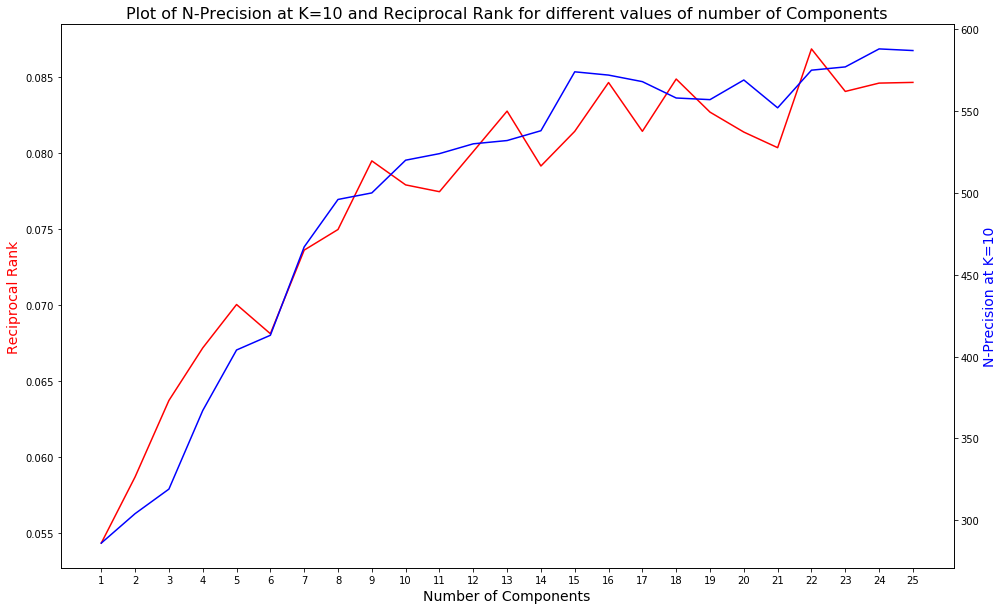

In [200]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [201]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo, item_features=full_item_features_csr)*10)))
print("Mean reciprocal rank across all users: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo, item_features=full_item_features_csr))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo, item_features=full_item_features_csr))))

Number of listened predictions across all users: 723
Mean reciprocal rank across all users: 0.092
Mean auc score across all users: 0.765


In [205]:
recommend_items(user = idx2user[1900], model=model, item_features=full_item_features_csr)

Listened Songs (from Train Dataset):
Artist: Boys Noize & Song: Let´s Buy Happiness
Artist: Coldplay & Song: In My Place
Artist: The Black Keys & Song: I'll Be Your Man
Artist: Cat Stevens & Song: Wild World
Artist: Simian Mobile Disco & Song: Simple

Recommended Songs:
Artist: Nine Inch Nails & Song: Closer
Artist: Pearl Jam & Song: Black
Artist: The Verve & Song: Bitter Sweet Symphony
Artist: Cake & Song: Frank Sinatra
Artist: Cat Stevens & Song: Wild World


## Running the Model on the Dense Dataset - Users who listened to >20 different songs

In [224]:
playcount_df = pd.read_csv('10kusers_500songs.csv')
song_info = pd.read_csv('song_info.csv')
genre = pd.read_csv('genre.csv')

In [225]:
df_song_info = pd.merge(playcount_df, song_info, how='inner', on='song_id')
df_song_info_genre = pd.merge(df_song_info, genre, how='inner', on='track_id')

In [226]:
user_song_counts = df_song_info_genre.groupby('user_id')['song_id'].count().reset_index()
user_song_counts.columns = ['user_id', 'song_counts']
sparse_users = user_song_counts[user_song_counts['song_counts']<10][['user_id']]
dense_users = user_song_counts[user_song_counts['song_counts']>20][['user_id']]

In [227]:
df_song_info_genre = pd.merge(df_song_info_genre, dense_users, how='inner', on='user_id')

In [228]:
%%capture --no-stderr
songs = df_song_info_genre['song_id'].unique()
users = df_song_info_genre['user_id'].unique()
genres = df_song_info_genre['genre'].unique()
artists = df_song_info_genre['artist_name'].unique()

# Users
user2idx = {u : i for i, u in enumerate(users)}
idx2user = {i : u for i, u in enumerate(users)}

# Songs
song2idx = {u : i for i, u in enumerate(songs)}
idx2song = {i : u for i, u in enumerate(songs)}

# Genre
genre2idx = {u : i for i, u in enumerate(genres)}
idx2genre = {i : u for i, u in enumerate(genres)}

# Artist
artist2idx = {u : i for i, u in enumerate(artists)}
idx2artist = {i : u for i, u in enumerate(artists)}

df_ids = df_song_info_genre[['user_id', 'song_id', 'listen_count']]
df_ids['song_id'] = df_ids['song_id'].map(song2idx)
df_ids['user_id'] = df_ids['user_id'].map(user2idx)

df_train, df_test = train_test_split(df_ids, train_size=0.8, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, train_size=0.8, test_size=0.2, random_state=42)

df_train_coo = convert_to_sparse_matrix(df_train, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))
df_val_coo = convert_to_sparse_matrix(df_val, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))
df_test_coo = convert_to_sparse_matrix(df_test, mat_type='coo', rows='user_id', cols='song_id', val='listen_count', shape=(len(idx2user), len(idx2song)))


song_genres = df_song_info_genre[['song_id', 'genre']].drop_duplicates()
song_genres['song_id'] = song_genres['song_id'].map(song2idx)
song_genres['genre'] = song_genres['genre'].map(genre2idx)
song_genres['onehot'] = 1
genre_csr = convert_to_sparse_matrix(song_genres, mat_type='csr', rows='song_id', cols='genre', val='onehot', shape=(len(idx2song), len(idx2genre)))
song_artists = df_song_info_genre[['song_id', 'artist_name']].drop_duplicates()
song_artists['song_id'] = song_artists['song_id'].map(song2idx)
song_artists['artist'] = song_artists['artist_name'].map(artist2idx)
song_artists['onehot'] = 1
artist_csr = convert_to_sparse_matrix(song_artists, mat_type='csr', rows='song_id', cols='artist', val='onehot', shape=(len(idx2song), len(idx2artist)))
full_item_features_csr = sc.sparse.csr_matrix(np.hstack((genre_csr.todense(), artist_csr.todense())))

/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Model with No Side Information

In [182]:
model, n_precision_at_k_test, mean_precision_at_k_test, reciprocal_rank_test, auc_score_test, metrics_df = build_lightfm_model(df_train_coo, df_val_coo,df_test_coo, item_features=None)

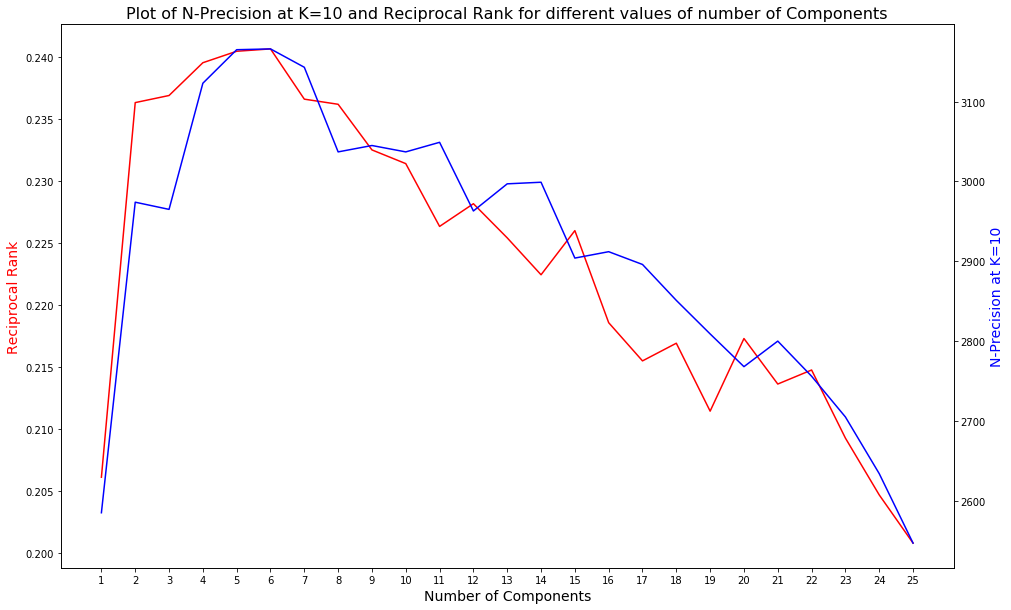

In [183]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [184]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo, item_features=None)*10)))
print("Mean reciprocal rank across all users: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo, item_features=None))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo, item_features=None))))

Number of listened predictions across all users: 3797
Mean reciprocal rank across all users: 0.265
Mean auc score across all users: 0.775


## Recomputation of baseline metrics on the dense dataset

In [185]:
baseline_top_items_n_precision_at_k(df_train_coo=df_train_coo, df_test_coo=df_test_coo, k=10)

2103.0

In [186]:
baseline_top_items_reciprocal_rank(df_train_coo=df_train_coo, df_test_coo=df_test_coo)

0.18666188081179336

In [188]:
recommend_items(user = idx2user[0], model=model, item_features=None)

Listened Songs (from Train Dataset):
Artist: Dwight Yoakam & Song: You're The One
Artist: the bird and the bee & Song: Again & Again
Artist: White Denim & Song: Transparency
Artist: The Black Keys & Song: I'll Be Your Man
Artist: John Mayer & Song: Half Of My Heart

Recommended Songs:
Artist: Coldplay & Song: The Scientist
Artist: Coldplay & Song: Clocks
Artist: Vampire Weekend & Song: A-Punk (Album)
Artist: Kings Of Leon & Song: Revelry
Artist: Five Iron Frenzy & Song: Canada


## Model with Artist and Genre Side Information

In [189]:
model, n_precision_at_k_test, mean_precision_at_k_test, reciprocal_rank_test, auc_score_test, metrics_df = build_lightfm_model(df_train_coo, df_val_coo,df_test_coo, item_features=full_item_features_csr)

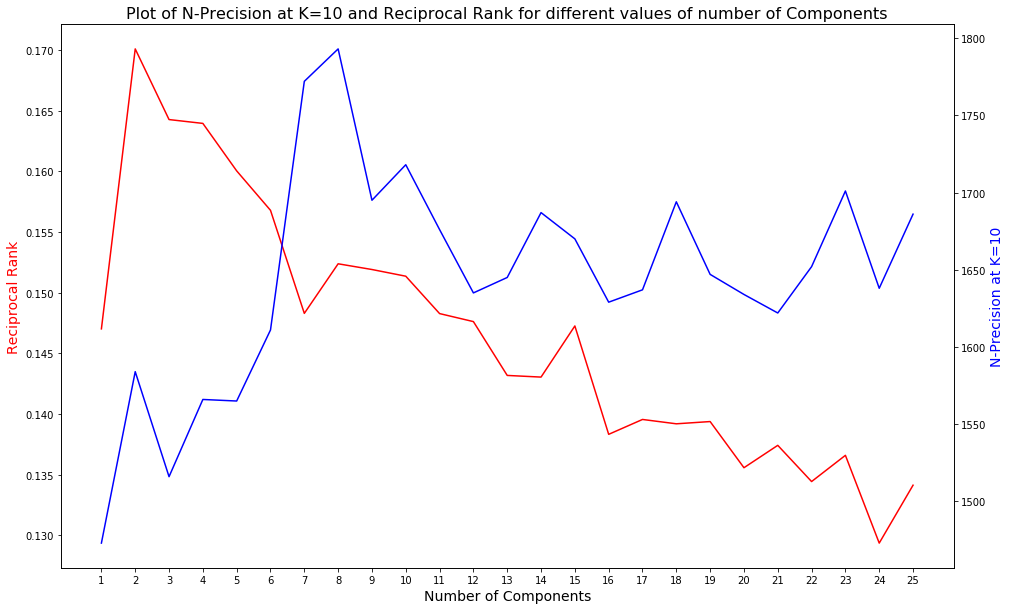

In [190]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax2 = ax1.twinx()
ax1.plot(range(1,26),metrics_df['reciprocal_rank'],'r-')
ax2.plot(range(1,26),metrics_df['n_precision_at_k'], 'b-')

ax1.set_xlabel('Number of Components', fontsize=14)
ax1.set_ylabel('Reciprocal Rank', color='r', fontsize=14)
ax2.set_ylabel('N-Precision at K=10', color='b', fontsize=14)

plt.xlabel('Number of Components', fontsize=16)
plt.title('Plot of N-Precision at K=10 and Reciprocal Rank for different values of number of Components', fontsize=16)
plt.xticks(range(1,26))
plt.show()

In [192]:
print("Number of listened predictions across all users:", int(sum(precision_at_k(model, df_test_coo, item_features=full_item_features_csr)*10)))
print("Mean reciprocal rank across all users: {0:.3f}".format(np.mean(reciprocal_rank(model, df_test_coo, item_features=full_item_features_csr))))
print("Mean auc score across all users: {0:.3f}".format(np.mean(auc_score(model, df_test_coo, item_features=full_item_features_csr))))

Number of listened predictions across all users: 2124
Mean reciprocal rank across all users: 0.164
Mean auc score across all users: 0.773


In [193]:
recommend_items(user = idx2user[1900], model=model, item_features=full_item_features_csr)

Listened Songs (from Train Dataset):
Artist: Emmy The Great & Song: Mia
Artist: Man Man & Song: Black Mission Goggles
Artist: Metric & Song: Patriach On A Vespa
Artist: Man Man & Song: Van Helsing Boombox
Artist: Rilo Kiley & Song: The Absence Of God (Album Version)

Recommended Songs:
Artist: Emmy The Great & Song: Mia
Artist: Soltero & Song: Acadian Coast
Artist: Soltero & Song: Ghost At The Foot Of The Bed
Artist: Soltero & Song: Michael
Artist: Soltero & Song: Hands Up
